**1 - Imports**

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import random as rd

**2 - Extract the data**

(1257,)
(1257,)


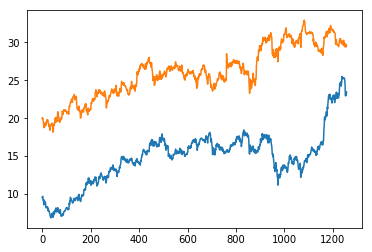

In [2]:
def extract_data(file_name):
    # Get the content of the file
    file_content = np.genfromtxt(file_name, delimiter=',')
    
    return file_content[1:, 4]

boa_data = extract_data('bank_of_america.csv')
ge_data = extract_data('ge.csv')

print(boa_data.shape)
print(ge_data.shape)
plt.plot([i for i in range(0, boa_data.shape[0])], boa_data)
plt.plot([i for i in range(0, boa_data.shape[0])], ge_data)

**3 - Separate the data in training and testing datasets**

In [4]:
def split_data(data, train_per=0.7):
    max_train = int(train_per * data.shape[0])
    
    return data[:max_train], data[max_train:]

boa_train, boa_test = split_data(boa_data)
ge_train, ge_test = split_data(ge_data)

**4 - Define the Portfolio object**

In [34]:
class Portfolio:
    
    # Amount of cash we have at the beginning
    BASE_CASH = 5000
    
    # Theoritical maximum amount of cash/shares we have. This is only for 
    # simplifying the data into discrete values, we can actually go beyond 
    # those values.
    MAX_CASH = 10000
    MAX_SHARENB = 1000
    
    # Number of share we buy/sell when we choose those actions
    BUY_SELL_NB = 100
    
    # Number of levels of Cash and Share number
    CASH_NB_VAL = 100
    SHARENB_NB_VAL = 10
    
    # Reward for doing a bad action
    BAD_ACTION_REWARD = -10
    
    def __init__(self):
        self.cash = self.BASE_CASH
        self.nb_shares = 0
        
        # Portfolio value over time
        self.value = [self.BASE_CASH]
        
    def sell(self, sh_value):
        # If we have shares to sell
        if self.nb_shares >= self.BUY_SELL_NB:
            # Update the number of shares and the cash balance
            self.nb_shares -= self.BUY_SELL_NB
            self.cash += sh_value * self.BUY_SELL_NB
            
            return 0
        # Else, we return a bad reward
        else:
            return self.BAD_ACTION_REWARD
        
    def buy(self, sh_value):
        # If we have enough cash to buy
        if self.cash >= self.BUY_SELL_NB * sh_value:
            # Update the number of shares and the cash balance
            self.nb_shares += self.BUY_SELL_NB
            self.cash -= sh_value * self.BUY_SELL_NB
            
            return 0
        # Else, we return a bad reward
        else:
            return self.BAD_ACTION_REWARD
        
    def compute_value(self, sh_value):
        """ Compute the value of the portfolio and returns profit. """
        # Append to the value vector the value of the current state
        self.value.append(self.cash + (self.nb_shares * sh_value))
        
        return self.value[-1] - self.value[-2]
        
    def get_discrete_cash(self):
        """ Return a discrete value corresponding to the level of cash currently held. """
        if self.cash >= self.MAX_CASH:
            #print('Cash over maximum.')
            return self.CASH_NB_VAL - 1
        return int(self.cash / (self.MAX_CASH / self.CASH_NB_VAL))

    def get_discrete_sharenb(self):
        """ Return a discrete value corresponding to the level of shares currently held. """
        if self.nb_shares >= self.MAX_SHARENB:
            print('Share number over maximum.')
            return self.SHARENB_NB_VAL - 1
        return int(self.nb_shares / (self.MAX_SHARENB / self.SHARENB_NB_VAL))

**5 - Create the Q-Learning model**

Q(st, at) ← (1 − α).Q(st, at) + α.(rt + γ.maxaQ(st + 1, a))

8941.364996200002


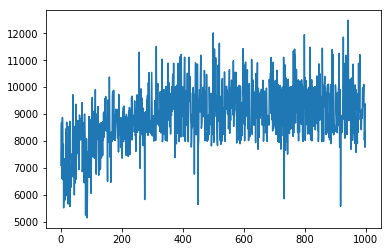

In [60]:
def get_growth_sign(growth):
    # Returns 0 is negative, 1 if null, 2 if positive
    if growth < -0.25:
        return 0
    elif growth <= 0:
        return 1
    #elif growth == 0:
    #    return 2
    elif growth <= 0.25:
        return 2
    else:
        return 3
    """if growth < 0:
        return 0
    elif growth == 0:
        return 1
    else:
        return 2"""

class QLearning:
    
    def __init__(self):
        self.pf = Portfolio()
        
        self.qtable = np.zeros((4 * self.pf.CASH_NB_VAL * self.pf.SHARENB_NB_VAL, 3))
        
        # Exploration rate
        self.eps = 1
        self.min_eps = 0.1
        self.decay_eps = 0.001
        
        # Learning rate
        self.lr = 0.001
        
        # Discount rate
        self.dr = 0.9
        
    def get_state_id(self, state):
        """ Returns the id of a state in the Q-table. """
        return state[0] * self.pf.CASH_NB_VAL * self.pf.SHARENB_NB_VAL + state[1] * self.pf.SHARENB_NB_VAL + state[2]
        
    def exploitation(self, state):
        """ Choose the action with the biggest Q-value in the Q-table. """
        # Get the id of the state in the Q-table
        state_id = self.get_state_id(state)
        
        # Get the biggest Q-value at that state
        qmax = np.amax(self.qtable[state_id])

        # If this is the Q-value for multiple actions, choose randomly between these actions
        count = np.count_nonzero(self.qtable[state_id] == qmax)
        if count > 1:
            rn = rd.randint(1, count + 1)
            act = 0
            for i in range(len(self.qtable[0])):
                if self.qtable[state_id, i] == qmax:
                    act = i
                    rn -= 1
                if rn == 0:
                    break
            return act
        else:
            return np.argmax(self.qtable[state_id])
        
    def exploration(self):
        """ Returns a random choice of action. """
        return rd.randint(0,2)
    
    def train(self, data):
        final_pf_values = []
        nb_train_episode = 1000
        
        for k in range(nb_train_episode):
            self.pf = Portfolio()
            
            for i in range(1, len(data)):
                # Reward
                r = 0

                # Get the current state: growth since last state, cash, number of shares
                growth = data[i] - data[i - 1]
                state = (get_growth_sign(growth), self.pf.get_discrete_cash(), self.pf.get_discrete_sharenb())

                # Choose an action
                if rd.random() > self.eps:
                    # Do exploitation
                    action = self.exploitation(state)
                else:
                    # Do exploration
                    action = self.exploration()
                # Decay epsilon
                if self.eps > self.min_eps:
                    self.eps -= self.decay_eps

                # Take action and get reward
                if action == 0:
                    r = self.pf.buy(data[i])
                elif action == 1:
                    r = self.pf.sell(data[i])

                profit = self.pf.compute_value(data[i])
                r += profit ** 3

                # Get new state
                if i == len(data) - 1:
                    new_groth = 0
                else:
                    new_growth = data[i + 1] - data[i]
                new_state = (get_growth_sign(new_growth), self.pf.get_discrete_cash(), self.pf.get_discrete_sharenb())

                # Update the Q-value
                self.qtable[self.get_state_id(state), action] += self.lr * (r + self.dr * np.amax(self.qtable[self.get_state_id(new_state)]) - self.qtable[self.get_state_id(state), action])
            
            final_pf_values.append(self.pf.value[-1])
        
        # Plot the final value of the portfolio for all episodes
        plt.plot([j for j in range(len(final_pf_values))], final_pf_values)  
        print(np.mean(final_pf_values))
    
    def test(self, data):
        # Create a new Portfolio
        self.pf = Portfolio()
        
        for i in range(1, len(data)):
            # Get the current state: growth since last state, cash, number of shares
            growth = data[i] - data[i - 1]
            state = (get_growth_sign(growth), self.pf.get_discrete_cash(), self.pf.get_discrete_sharenb())
                
            # Choose an action with exploitation policy
            action = self.exploitation(state)
            
            # Take action and get reward
            if action == 0:
                self.pf.buy(data[i])
            elif action == 1:
                self.pf.sell(data[i])
            
            # Compute the value
            self.pf.compute_value(data[i])
            
        plt.plot([j for j in range(len(self.pf.value))], self.pf.value) 
        print(self.pf.value[-1])
            
ql = QLearning()
ql.train(boa_train)

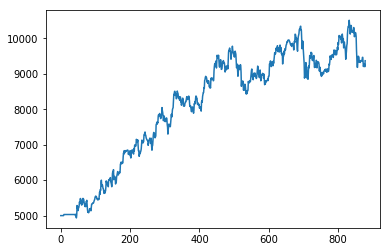

In [61]:
plt.plot([j for j in range(len(ql.pf.value))], ql.pf.value)  

**6 - Test on new data**

7311.999900000001


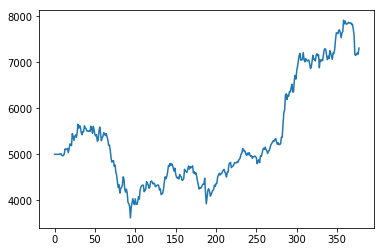

In [64]:
ql.test(boa_test)

**7 - Let's look at the data from GE now**

5886.784852


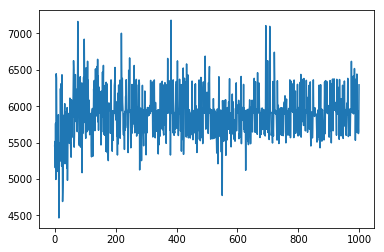

In [67]:
ql2 = QLearning()
ql2.train(ge_train)

5579.000800000001


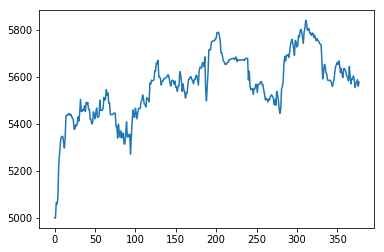

In [68]:
ql2.test(ge_test)

To continue, we can have another idea for the states: taking a simplified version of the share in consideration

0.19
0.15


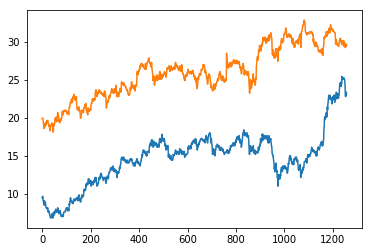

In [69]:
def simplify(data, nb_values_max):
    simple_data = np.zeros(data.shape)
    
    # Get the step
    step = float('%.2f'%((np.max(data) - np.min(data)) / nb_values_max))
    
    # Replace each values with multiples of the step
    for i in range(nb_values_max):
        simple_data[data >= (np.min(data) + (i * step))] = np.min(data) + (i * step)
    
    return simple_data, step

nb_values = 100
boa_simple, boa_step = simplify(boa_data, nb_values)
ge_simple, ge_step = simplify(ge_data, nb_values)

print(boa_step)
print(ge_step)

plt.plot([i for i in range(0, boa_simple.shape[0])], boa_simple)
plt.plot([i for i in range(0, boa_simple.shape[0])], ge_simple)